In [1]:
import  numpy               as      np
import  matplotlib.pyplot   as      plt

from    tqdm.notebook       import  tqdm

from    pathlib     import  Path
import  sys
sys.path.append(str(Path.cwd().parent.parent))

from    numerical           import  utils, distribution
from    numerical.solvers   import  FastSM_Boltzmann_VHS

In [2]:
DIMENSION:  int = 2
RESOLUTION: int = 16

T1__size, T2__size, T3__size = 1000, 1000, 1000
V_MAX:      float = 5.0
DELTA_V:    float = (2*V_MAX) / RESOLUTION

v_grid = utils.velocity_grid(DIMENSION, RESOLUTION, V_MAX)

FFT_AXES:   tuple[int] = tuple(range(-(1+DIMENSION), -1))
FFT_NORM:   str  = 'forward'

VHS_COEFF = 1 / utils.area_of_unit_sphere(DIMENSION)

In [3]:
def sample_quantities(
        batch_size:     int,
        v_perturb_max:  float = 1.0,
        t_perturb_max:  float = 0.2,
    ) -> tuple[np.ndarray]:
    """Sample the mean density, velocity, and temperatures."""
    rho = np.ones((batch_size, 1))
    u   = v_perturb_max *(2*np.random.rand(batch_size, DIMENSION) - 1)
    t   = np.power(1 + np.sqrt(t_perturb_max) * (2*np.random.rand(batch_size, 1) - 1), 2)
    return rho, u, t


def sample_noise_quadratic(
        batch_size:     int,
        dimension:      int,
        max_v:          float,
    ) -> tuple[np.ndarray]:
    """Sample the quadratic noise $q$, for which $1 + q >= 0$."""
    dim_simplex = int(np.sum([np.power(dimension, i) for i in range(0, dimension+1)]))
    __coeffs: np.ndarray
    __coeffs = np.random.dirichlet([1 for _ in range(dim_simplex+1)], size=batch_size)
    __coeffs = __coeffs * np.random.choice([-1, 1], size=__coeffs.shape)
    
    __split_arg = np.cumsum([ dimension**k for k in range(0, 2+1) ])
    coeffs = np.split(__coeffs, __split_arg, axis=-1)
    coeffs.pop(-1)
    
    return tuple((
        np.reshape(
            c/(max_v**k),
            (batch_size, *(dimension for _ in range(k)))
        )
        for k, c in enumerate(coeffs)
    ))


def compute_quadratic_polynomial(x: np.ndarray, coeffs: tuple[np.ndarray]) -> np.ndarray:
    assert coeffs[0].shape[0]==coeffs[1].shape[0] and coeffs[1].shape[0]==coeffs[2].shape[0]
    ord_0:  np.ndarray = coeffs[0].reshape(-1, *utils.ones(DIMENSION))
    ord_1:  np.ndarray = np.einsum(f"...i, bi -> b...", x, coeffs[1])
    ord_2:  np.ndarray = np.einsum(f"...i, bij, ...j -> b...", x, coeffs[2], x)
    return ord_0+ord_1+ord_2


def normalize_density(f: np.ndarray) -> np.ndarray:
    """Normalize the density to 1."""
    density: np.ndarray
    density = f.sum(tuple(range(-1-DIMENSION, -1))) * (DELTA_V**DIMENSION)
    density = density.reshape((-1, *utils.ones(2*DIMENSION+1)))
    return f/density

Type 1. Maxwellian distribution

In [4]:
T1__data: np.ndarray = distribution.maxwellian_homogeneous(v_grid, *sample_quantities(T1__size))
T1__data = normalize_density(T1__data)

print(f"The shape of the data >>> {T1__data.shape}")

The shape of the data >>> (1000, 1, 1, 16, 16, 1)


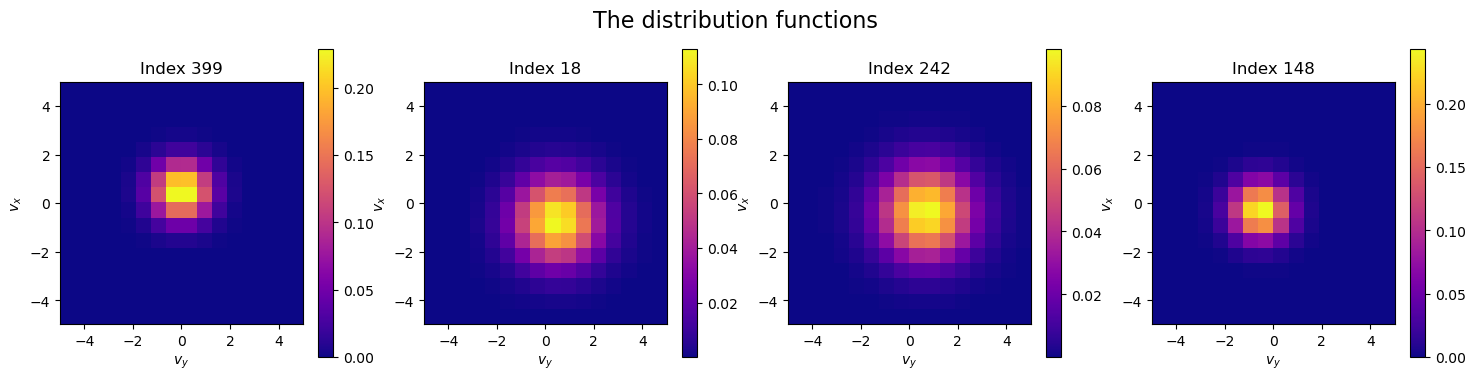

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=100)
fig.suptitle("The distribution functions", fontsize=16)
for idx_ax, idx_f in enumerate(np.random.randint(0, T1__size, size=4)):
    axes[idx_ax].set_title(f"Index {idx_f}")
    fig.colorbar(
        axes[idx_ax].imshow(
            T1__data[idx_f].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=(-V_MAX, V_MAX, -V_MAX, V_MAX),
            cmap='plasma',
        )
    )
    axes[idx_ax].set_xlabel(r"$v_y$")
    axes[idx_ax].set_ylabel(r"$v_x$")
plt.show()

Type 2. Sum of two Maxwellian distributions

In [6]:
T2__data: np.ndarray = \
    0.5 * (
        distribution.maxwellian_homogeneous(v_grid, *sample_quantities(T2__size))
        +
        distribution.maxwellian_homogeneous(v_grid, *sample_quantities(T2__size))
    )
T2__data = normalize_density(T2__data)

print(f"The shape of the data >>> {T2__data.shape}")

The shape of the data >>> (1000, 1, 1, 16, 16, 1)


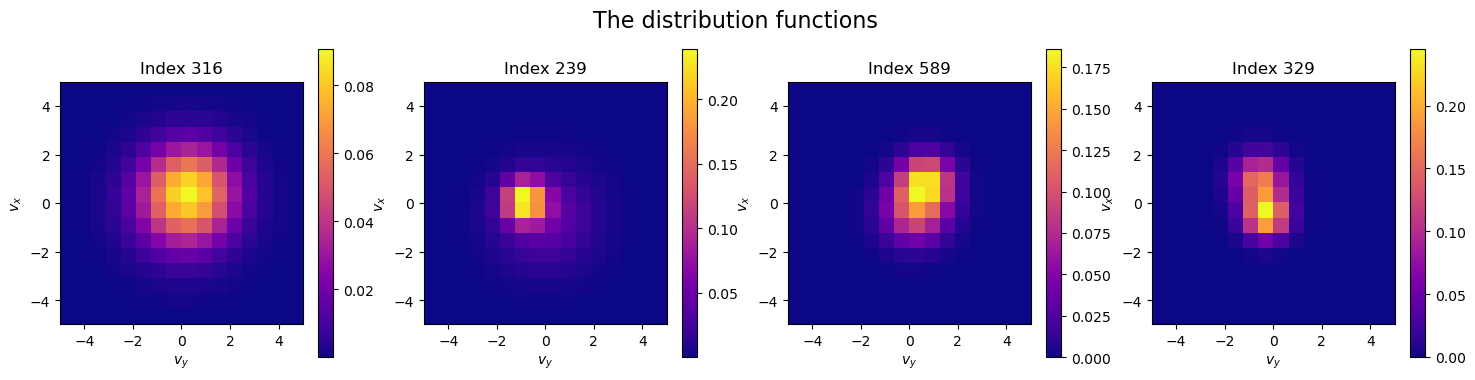

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=100)
fig.suptitle("The distribution functions", fontsize=16)
for idx_ax, idx_f in enumerate(np.random.randint(0, T2__size, size=4)):
    axes[idx_ax].set_title(f"Index {idx_f}")
    fig.colorbar(
        axes[idx_ax].imshow(
            T2__data[idx_f].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=(-V_MAX, V_MAX, -V_MAX, V_MAX),
            cmap='plasma',
        )
    )
    axes[idx_ax].set_xlabel(r"$v_y$")
    axes[idx_ax].set_ylabel(r"$v_x$")
plt.show()

Type 3. Perturbed Maxwellian distributions

In [8]:
coeffs = sample_noise_quadratic(T3__size, DIMENSION, V_MAX+1)
# coeffs = (
#     np.random.uniform(-1, 1, size=(T3__size,)),
#     np.random.uniform(-1, 1, size=(T3__size, DIMENSION)),
#     np.random.uniform(-1, 1, size=(T3__size, DIMENSION, DIMENSION)),
# )

c0, c1, c2 = coeffs
c0 = np.abs(c0).reshape(T3__size,-1)
c1 = np.abs(c1 * V_MAX).reshape(T3__size,-1)
c2 = np.abs(c2 * V_MAX**2).reshape(T3__size,-1)

quad = compute_quadratic_polynomial(v_grid, coeffs)
quad = quad.reshape(T3__size, *utils.ones(DIMENSION), *utils.repeat(RESOLUTION, DIMENSION), 1)

T3__data: np.ndarray = \
    distribution.maxwellian_homogeneous(v_grid, *sample_quantities(T3__size)) * \
    (1 + quad)

T3__data = normalize_density(T3__data)
print(f"The shape of the data >>> {T3__data.shape}")

The shape of the data >>> (1000, 1, 1, 16, 16, 1)


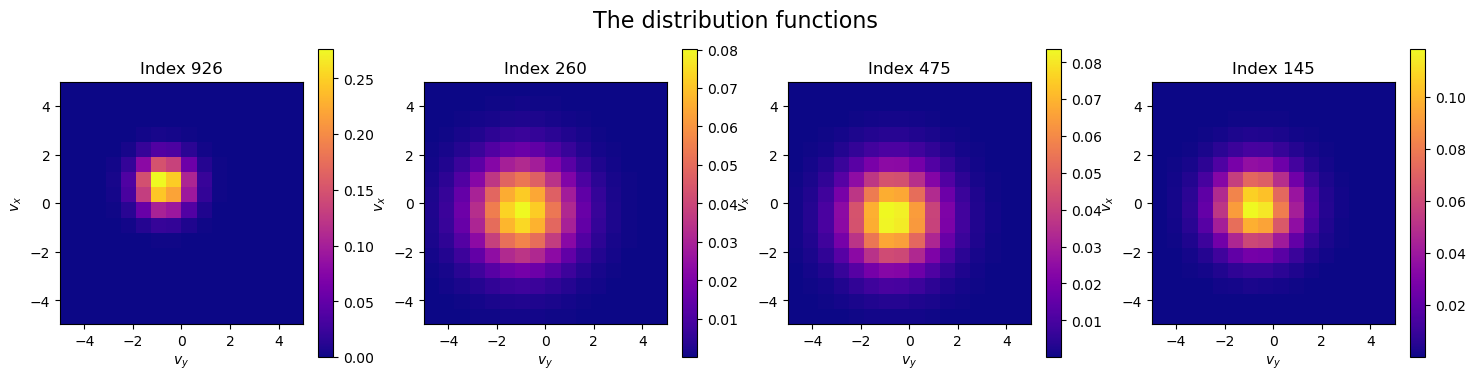

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=100)
fig.suptitle("The distribution functions", fontsize=16)
for idx_ax, idx_f in enumerate(np.random.randint(0, T3__size, size=4)):
    axes[idx_ax].set_title(f"Index {idx_f}")
    fig.colorbar(
        axes[idx_ax].imshow(
            T3__data[idx_f].reshape(*utils.repeat(RESOLUTION, DIMENSION)),
            extent=(-V_MAX, V_MAX, -V_MAX, V_MAX),
            cmap='plasma',
        )
    )
    axes[idx_ax].set_xlabel(r"$v_y$")
    axes[idx_ax].set_ylabel(r"$v_x$")
plt.show()

Type 4. The BKW solutions

In [10]:
bkw_sol = distribution.bkw(np.zeros((1,)), v_grid, vhs_coeff=1/utils.area_of_unit_sphere(DIMENSION), coeff_ext=0.5)[0]
print(bkw_sol.shape)

----------[ BKW solution ]----------
* coeff_ext: 0.5
* coeff_int: 0.125
------------------------------------
(1, 1, 1, 16, 16, 1)


Merge the data

In [11]:
dataset = np.concatenate((T1__data, T2__data, T3__data), axis=0)
print(f"The shape of the dataset >>> {dataset.shape}")

The shape of the dataset >>> (3000, 1, 1, 16, 16, 1)


In [12]:
n_split = 60
assert dataset.shape[0] % n_split == 0

In [13]:
solver_maxwellian = FastSM_Boltzmann_VHS(
    dim         = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = V_MAX,
    vhs_alpha   = 0.0,
    vhs_coeff   = VHS_COEFF,
    
    quad_order_uniform  = 25,
    quad_order_legendre = 50,
    quad_order_lebedev  = 7,
)
solver_maxwellian.precompute()

solver_hard_sphere = FastSM_Boltzmann_VHS(
    dim         = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = V_MAX,
    vhs_alpha   = 1.0,
    vhs_coeff   = VHS_COEFF,
    
    quad_order_uniform  = 25,
    quad_order_legendre = 50,
    quad_order_lebedev  = 7,
)
solver_hard_sphere.precompute()

In [14]:
bkw_fft     = np.fft.fftn(bkw_sol, s=(RESOLUTION,RESOLUTION), axes=FFT_AXES, norm=FFT_NORM)
Q_bkw_fft   = solver_maxwellian.compute_collision_fft(None, bkw_fft)
Q_bkw = np.fft.ifftn(Q_bkw_fft, s=(RESOLUTION,RESOLUTION), axes=FFT_AXES, norm=FFT_NORM).real
print(f"The shape of the BKW solution >>> {Q_bkw.shape}")

The shape of the BKW solution >>> (1, 1, 1, 16, 16, 1)


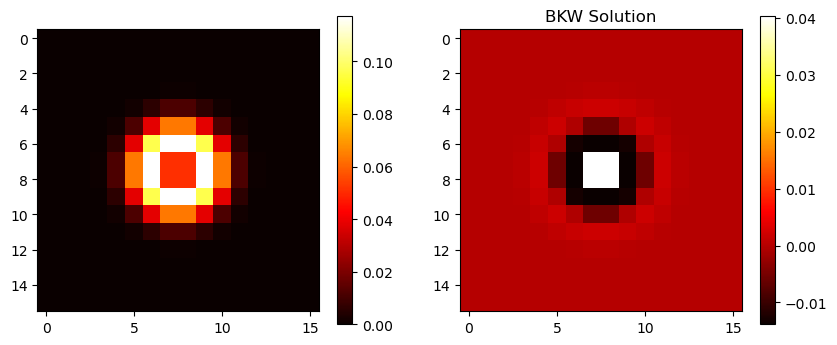

In [15]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
fig.colorbar(
    axes[0].imshow(bkw_sol[idx,0,0,:,:,0], cmap='hot', interpolation='nearest')
)
fig.colorbar(
    axes[1].imshow(Q_bkw[idx,0,0,:,:,0], cmap='hot', interpolation='nearest')
)
plt.title("BKW Solution")
plt.show()

In [16]:
# Compute the collision terms
Q_fft_alpha_0_gain: list[np.ndarray]    = []
Q_fft_alpha_0_loss: list[np.ndarray]    = []
Q_fft_alpha_1_gain: list[np.ndarray]    = []
Q_fft_alpha_1_loss: list[np.ndarray]    = []

for _dataset in tqdm(np.split(dataset, n_split, axis=0)):
    _dataset_fft = np.fft.fftn(_dataset, axes=FFT_AXES, norm=FFT_NORM)

    # 1. Maxwellian molecules
    _Q_fft_alpha_0_gain = solver_maxwellian.compute_collision_gain_fft(None, _dataset_fft)
    _Q_fft_alpha_0_loss = solver_maxwellian.compute_collision_loss_fft(None, _dataset_fft)
    Q_fft_alpha_0_gain.append(_Q_fft_alpha_0_gain)
    Q_fft_alpha_0_loss.append(_Q_fft_alpha_0_loss)

    # 2. Hard spheres
    _Q_fft_alpha_1_gain = solver_hard_sphere.compute_collision_gain_fft(None, _dataset_fft)
    _Q_fft_alpha_1_loss = solver_hard_sphere.compute_collision_loss_fft(None, _dataset_fft)
    Q_fft_alpha_1_gain.append(_Q_fft_alpha_1_gain)
    Q_fft_alpha_1_loss.append(_Q_fft_alpha_1_loss)

Q_fft_alpha_0_gain  = np.concatenate(Q_fft_alpha_0_gain, axis=0)
Q_fft_alpha_0_loss  = np.concatenate(Q_fft_alpha_0_loss, axis=0)
Q_fft_alpha_1_gain  = np.concatenate(Q_fft_alpha_1_gain, axis=0)
Q_fft_alpha_1_loss  = np.concatenate(Q_fft_alpha_1_loss, axis=0)

  0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
np.savez(f"Boltzmann__alpha_0__res_{RESOLUTION}.npz", data=dataset, gain_fft=Q_fft_alpha_0_gain, loss_fft=Q_fft_alpha_0_loss)
np.savez(f"Boltzmann__alpha_1__res_{RESOLUTION}.npz", data=dataset, gain_fft=Q_fft_alpha_1_gain, loss_fft=Q_fft_alpha_1_loss)
print(f"Done")

Done


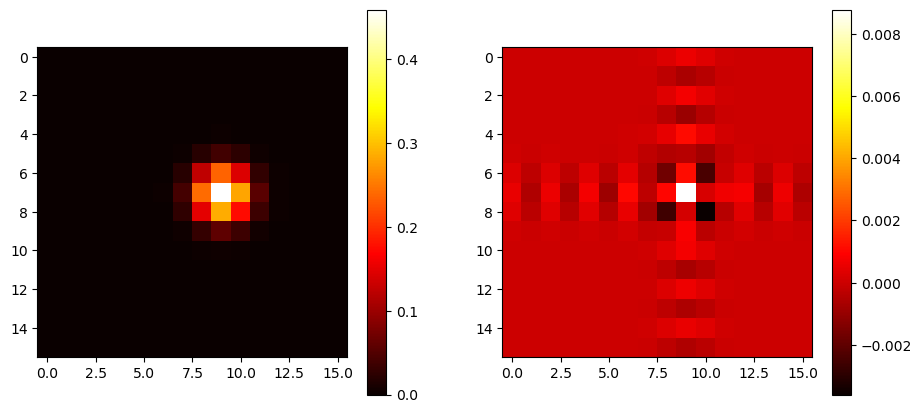

In [18]:
Q_alpha_0_gain = np.fft.ifftn(Q_fft_alpha_0_gain, axes=FFT_AXES, norm=FFT_NORM).real
Q_alpha_0_loss = np.fft.ifftn(Q_fft_alpha_0_loss, axes=FFT_AXES, norm=FFT_NORM).real
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
idx = 154
fig.colorbar(
    axes[0].imshow((dataset)[idx].reshape(RESOLUTION, RESOLUTION), cmap='hot', interpolation='nearest')
)
fig.colorbar(
    axes[1].imshow((Q_alpha_0_gain-Q_alpha_0_loss)[idx].reshape(RESOLUTION, RESOLUTION), cmap='hot', interpolation='nearest')
)
plt.show()

End of file